100%|██████████| 9.70M/9.70M [00:00<00:00, 114MB/s]
100%|██████████| 463k/463k [00:00<00:00, 14.4MB/s]
100%|██████████| 9.74M/9.74M [00:00<00:00, 148MB/s]
100%|██████████| 527k/527k [00:00<00:00, 20.8MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.1472, Train Acc: 95.56%, Val Acc: 97.55%
Epoch [2/10], Loss: 0.0556, Train Acc: 98.31%, Val Acc: 98.18%
Epoch [3/10], Loss: 0.0399, Train Acc: 98.79%, Val Acc: 98.82%
Epoch [4/10], Loss: 0.0349, Train Acc: 98.92%, Val Acc: 98.78%
Epoch [5/10], Loss: 0.0293, Train Acc: 99.09%, Val Acc: 98.77%
Epoch [6/10], Loss: 0.0252, Train Acc: 99.19%, Val Acc: 99.09%
Epoch [7/10], Loss: 0.0263, Train Acc: 99.22%, Val Acc: 98.42%
Epoch [8/10], Loss: 0.0237, Train Acc: 99.26%, Val Acc: 98.89%
Epoch [9/10], Loss: 0.0200, Train Acc: 99.36%, Val Acc: 98.90%
Epoch [10/10], Loss: 0.0189, Train Acc: 99.39%, Val Acc: 98.82%
Accuracy on QMNIST test set: 98.61%


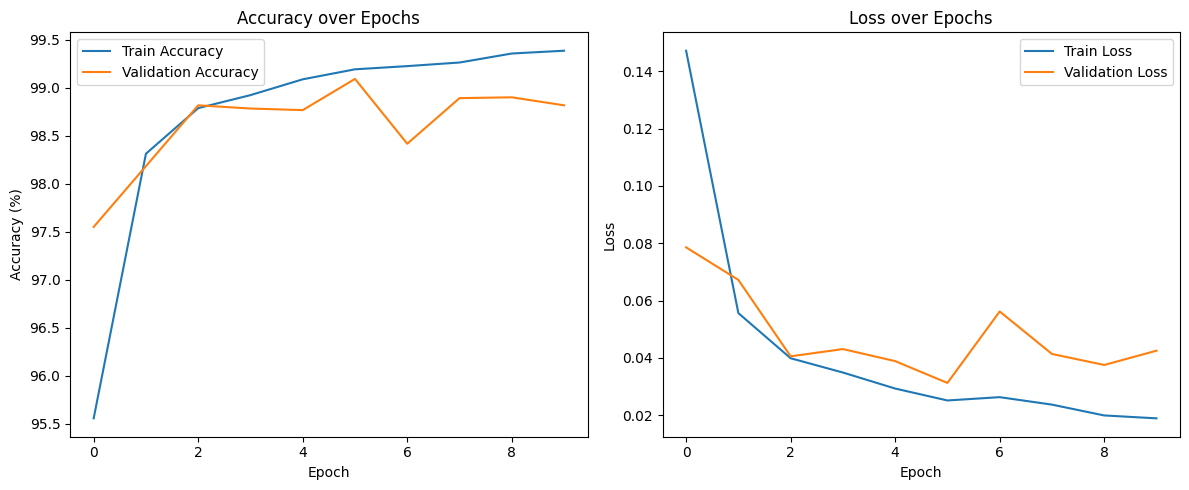

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# QMNIST dataset (32x32 grayscale images)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.QMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.QMNIST(root='./data', train=False, download=True, transform=transform)

# Splitting the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# ResNet model (adapted for QMNIST and 32x32 input)
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        # Using the pre-trained ResNet18 and modifying it for QMNIST
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)  # QMNIST has 10 classes

    def forward(self, x):
        return self.resnet(x)

# Custom He + Orthogonal initialization
def custom_init(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight)
        if hasattr(module, 'bias') and module.bias is not None:
            nn.init.constant_(module.bias, 0)

# Model setup
model = ResNet18().to(device)
custom_init(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics for plotting
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_acc = 100 * correct_train / total_train
    train_acc_list.append(train_acc)
    train_loss_list.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss / len(val_loader))

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

# Evaluation on test set
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

print(f'Accuracy on QMNIST test set: {100 * correct_test / total_test:.2f}%')

# Plot results
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
